# Exploratory Data Analysis
This notebook aims for presenting some initial EDA of the Amazon review dataset.

We could gain more intuition by studying the statistical properties of review ratings and other characteristics like length and word count. Furthermore, we also explore the datetime data in the Amazon review dataset. 

Note that this notebook contains EDAs that are not immediately related to the modeling. This separation is for simplicity in the other notebook. We also studied the missing values and text-based features in the notebook titled "modeling.ipynb".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [2]:
# save json file to the dataframe
df = pd.read_json("data/All_Beauty_5.json.gz", lines = True)
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN


## Rating distribution for reviewers that are verified or not
This investigates the statistical difference between the reviews' rating behaviours and see if there is any significant differentiation needed to be accounted in analysis.

/Users/danielsitompul/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Rating distribution of verified and unverified users')

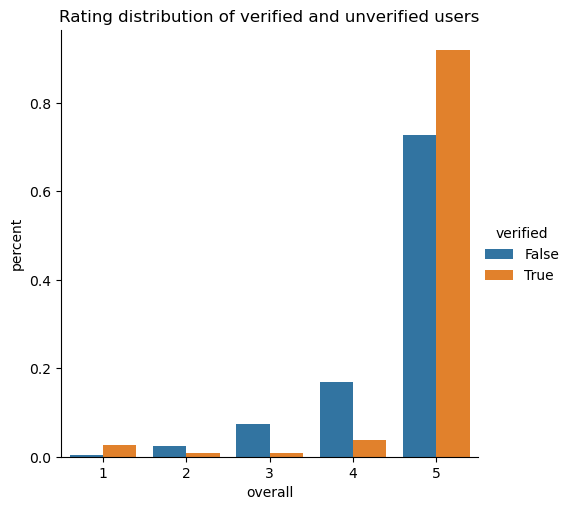

In [3]:
(
    df
    .groupby("verified")["overall"]
    .value_counts(normalize=True)
    .rename("percent")
    .reset_index()
    .pipe(
        (sns.catplot, "data"), 
        x = "overall", 
        y = "percent", 
        hue = "verified", 
        kind = "bar"
    )
)
plt.title("Rating distribution of verified and unverified users")

## Standard deviation of rating distribution 
We only consider reviewers with more than two reviews. This investigates the reviews' individual rating behaviour. More concentration at zero means a large portion of reviewers tend to give consistent rating cross all products. 

/Users/danielsitompul/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'The distribution of standard deviation of the rating by verified\n or unverified users who gave at least three ratings')

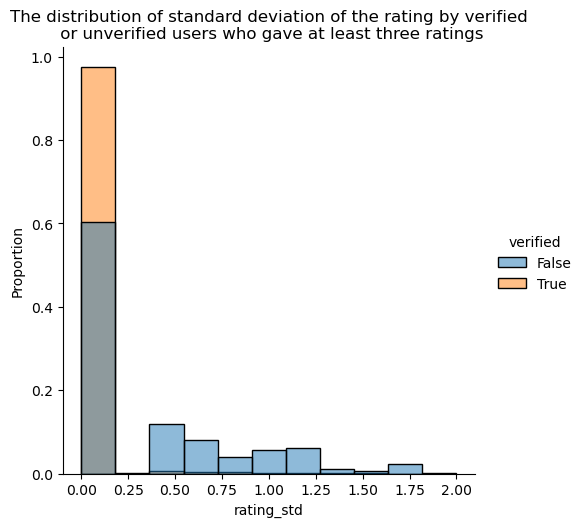

In [4]:
df_at_least_three_ratings_std = \
(
    df[["overall", "reviewerID", "verified"]]
    .groupby("reviewerID")
    .filter(lambda sf: len(sf) >= 3)
    .groupby("reviewerID")
    .agg({"overall": "std", "verified": "first"})
    .rename(columns = {"overall": "rating_std"})
)
sns.displot(data = df_at_least_three_ratings_std, x = "rating_std", stat = "proportion", hue = "verified", common_norm=False)
plt.title("The distribution of standard deviation of the rating by verified\n or unverified users who gave at least three ratings")

### Correlation between the mean rating and mean adjusted rating
The adjusted rating score is calculated by boosting the rating by a sublinear function of vote counts. Given a product $p$, let all its reviews be $\{(r_{i,p}, v_{i, p}) : i \in \mathrm{Review}(p)\}$ and $N_p = |\mathrm{Review}(p)|$. Then, the adjusted rating score is 
$$\hat{R}_p = \sum_{i = 1}^{N_p} r_{i, p} \log(2 + v_{i, p}) / \sum_{i = 1}^{N_p} \log(2 + v_{i, p}).$$
In contrast, the average rating score is
$$\hat{R}_p = \sum_{i = 1}^{N_p} r_{i, p} / N_p.$$
Both scores are normalized. In the following test, we study the correlation between these two scores.

/var/folders/6v/tq1c3nsj2w9grg3rf21vt_v40000gn/T/ipykernel_43019/222909104.py:23: UserWarning: The figure layout has changed to tight
  p.fig.tight_layout()


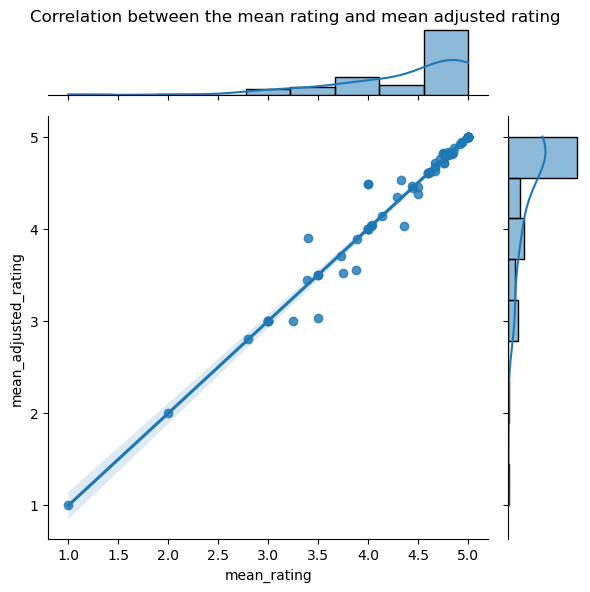

In [5]:
# fill nan with zero
df["vote"] = (
    df["vote"].str.replace(",", "")
    .fillna(0)
    .astype(int)
)
df["adjusted_vote"] = np.log(2 + df["vote"])
df["adjusted_rating"] = df["overall"] * df["adjusted_vote"]
df_product_score = (
    df[["overall", "asin", "adjusted_vote", "adjusted_rating"]]
    .groupby("asin")
    .mean()
    .rename(columns = {"overall": "mean_rating"})
)
df_product_score["mean_adjusted_rating"] = df_product_score["adjusted_rating"] / df_product_score["adjusted_vote"]
p = sns.jointplot(
    data = df_product_score, 
    x = "mean_rating",
    y = "mean_adjusted_rating",
    kind = "reg"
)
p.fig.suptitle("Correlation between the mean rating and mean adjusted rating")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

## Distribution of review length and word count
We study the review length, word count and their distribution.

In [6]:
# mean of review length
df.groupby('overall')['reviewText'].apply(lambda x: x.str.len().mean())

overall
1    196.930435
2    466.140625
3    596.321101
4    365.798193
5    177.742033
Name: reviewText, dtype: float64

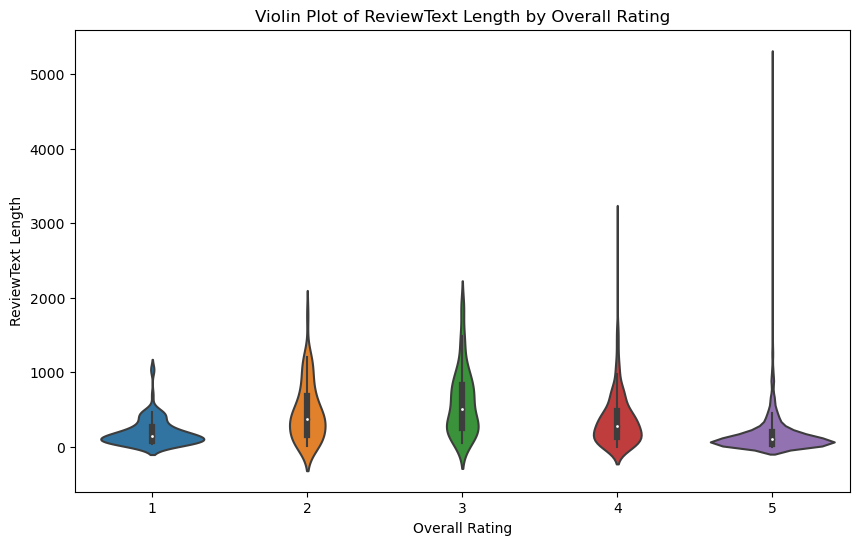

In [7]:
df['reviewText_length'] = df['reviewText'].str.len()
plt.figure(figsize=(10, 6))
sns.violinplot(x='overall', y='reviewText_length', data=df)
plt.title('Violin Plot of ReviewText Length by Overall Rating')
plt.xlabel('Overall Rating')
plt.ylabel('ReviewText Length')
plt.show()

In the following figure, we can see that the distribution properties of these two variables are very similar.

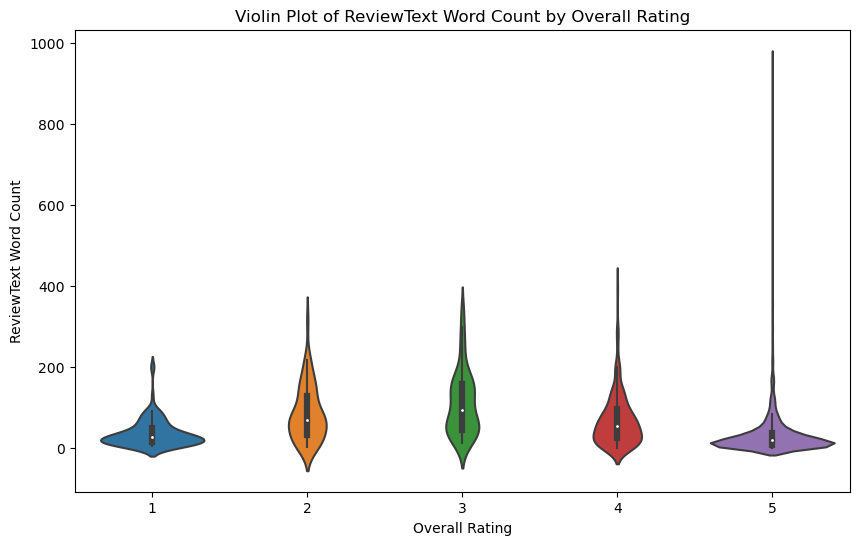

In [8]:
# Calculate the number of words in each 'reviewText' and store it in a new column
df['reviewText_word_count'] = df['reviewText'].apply(lambda x: len(str(x).split()))

# Create a violin plot using Seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x='overall', y='reviewText_word_count', data=df)
plt.title('Violin Plot of ReviewText Word Count by Overall Rating')
plt.xlabel('Overall Rating')
plt.ylabel('ReviewText Word Count')
plt.show()

## Explore datetime data
processing the dataset

In [9]:
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')  # Convert Unix time to datetime
df['date'] = df['unixReviewTime'].dt.day  # Extract day
df['month'] = df['unixReviewTime'].dt.month  # Extract month
df['year'] = df['unixReviewTime'].dt.year  # Extract year
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,adjusted_vote,adjusted_rating,reviewText_length,reviewText_word_count,date,month,year
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,2016-09-01,0,NaN,0.693147,3.465736,32.0,4,1,9,2016
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,2013-11-14,0,NaN,0.693147,3.465736,207.0,44,14,11,2013
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,2013-08-18,0,NaN,0.693147,0.693147,142.0,30,18,8,2013
3,5,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,2011-05-03,25,NaN,3.295837,16.479184,1417.0,266,3,5,2011
4,5,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,2011-05-06,3,NaN,1.609438,8.047190,237.0,45,6,5,2011


## Year-wise review count
We want to see the number of reviews that we have each year. Here we see that the oldest review is from 2004. Moreover, most reviews (~ > 75%) are from within 2012 to 2018. This shows that the data isn't well spread within all the years.

year
2018     443
2017     825
2016    1232
2015    1032
2014     784
2013     756
2012     111
2011      20
2010       4
2009      25
2008      20
2007      13
2006       2
2005       1
2004       1
Name: count, dtype: int64

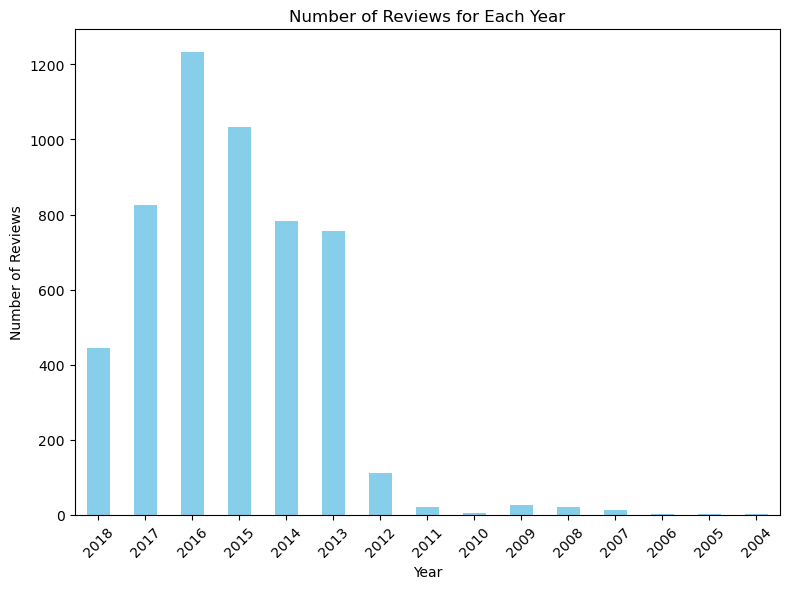

In [10]:
year_counts = df['year'].value_counts().sort_index(ascending=False)
display(year_counts)

plt.figure(figsize=(8, 6))
year_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for Each Year')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

## Seasional trends in review counts
Here we want to understand the number of reviews that are based in every month within different years. We realize that for some months of the year there are an increase number of reviews. For example, in between July to September, there is an significant increase. Also in March or April.

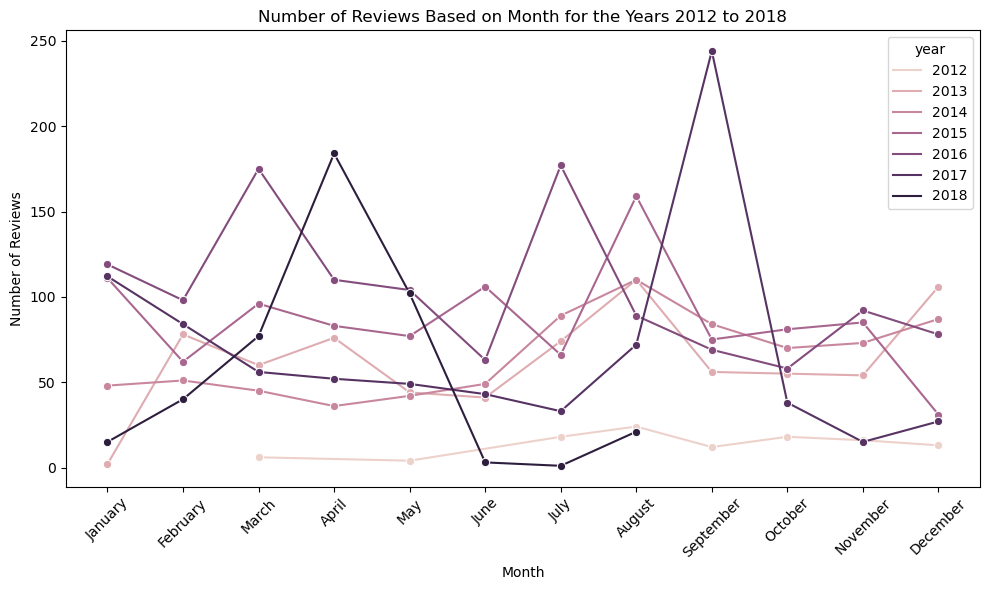

In [11]:
# Filter data for the years 2013 to 2018
filtered_df = df[(df['year'] >= 2012) & (df['year'] <= 2018)]

# Group by 'year' and 'month', then count the number of rows in each group
monthly_counts = filtered_df.groupby(['year', 'month']).size().reset_index(name='count')

# Set a custom color palette for higher contrast (using the "deep" palette)
sns.set_palette("deep")

# Create a line plot for the years 2013 to 2018
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_counts, x='month', y='count', hue='year', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Based on Month for the Years 2012 to 2018')
plt.xticks(range(1, 13), calendar.month_name[1:13], rotation=45)
plt.tight_layout()
plt.show()

We then want to see the number overall rating based on the months. Here we see that the rating varies within months, however, we still see there is a different trend in every month even though it's clear that most people opt to give rating 5. 

overall,1,2,3,4,5
month,,,,,
January,0,1,3,30,376
February,10,0,2,16,390
March,36,19,12,7,444
April,30,12,17,25,464
May,25,10,20,7,383
June,0,1,6,32,269
July,0,2,3,53,406
August,6,0,6,22,564
September,3,13,31,82,421


Text(0.5, 1.0, 'Rating vs Month')

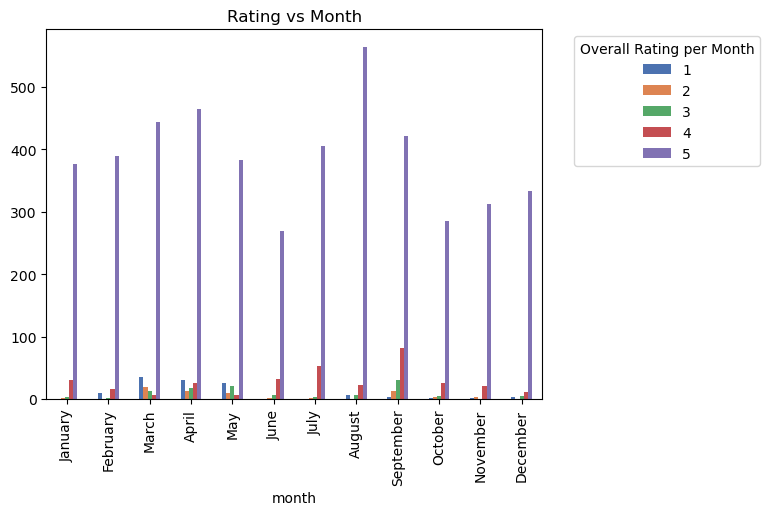

In [12]:
# Group by month and overall, then count occurrences
month_overall_counts = df.groupby(['month', 'overall']).size().unstack(fill_value=0)

month_overall_counts['month'] = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_overall_counts = month_overall_counts.set_index('month')

display(month_overall_counts)

month_overall_counts.plot(kind='bar')
plt.legend(title='Overall Rating per Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Rating vs Month')

## Day-wise review count
Here we also want to know the amount of reviews within the days of the week. We want to check if there is a significant difference on the amount of reviews in a certain day of the week. This shows that there are an even distribution of review data on every day in the week.

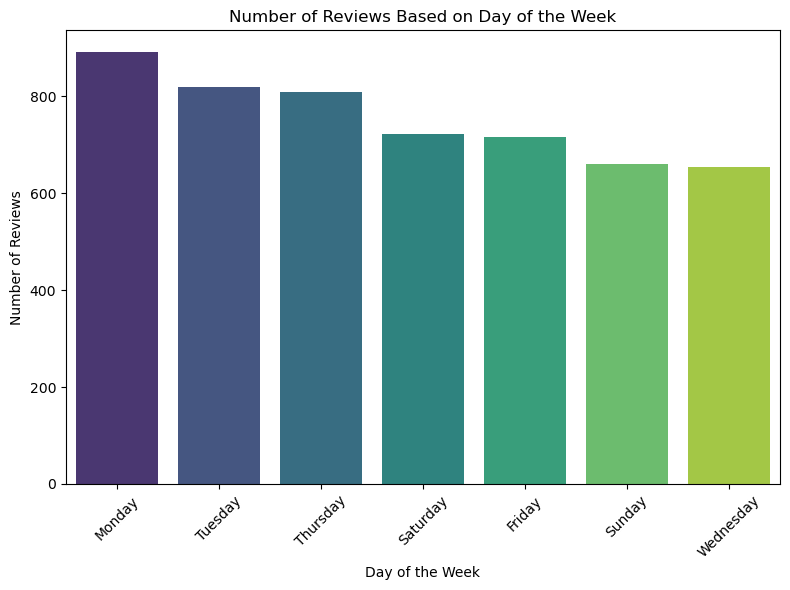

In [13]:
df['day_of_week'] = df['unixReviewTime'].dt.day_name()

# Count the number of reviews for each day of the week
reviews_by_day = df['day_of_week'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=reviews_by_day.index, y=reviews_by_day.values, palette='viridis')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Based on Day of the Week')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

## Year-wise statistical difference
Lastly, we want to understand the spread of the rating given by users within different years. We realized that for most years, the third quartile are on the 5 rating, only 2006, 2008, 2011, and 2018 rating distributions are not. This shows that for some years people may have more variance of rating than others.

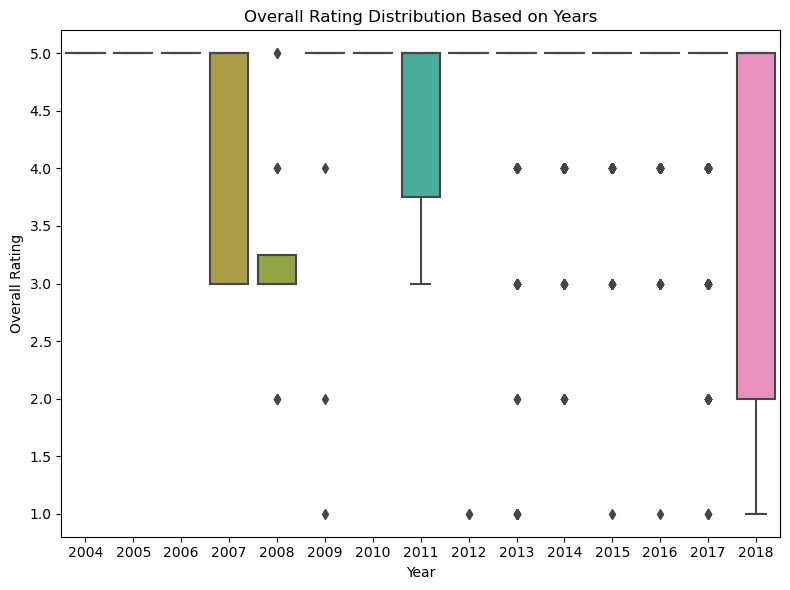

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='year', y='overall')
plt.xlabel('Year')
plt.ylabel('Overall Rating')
plt.title('Overall Rating Distribution Based on Years')
plt.tight_layout()
plt.show()

## Understanding The Trend of Rating Based on User Verification

We now try to understand the trend of rating based on user verification

1. User verification vs the overall rating

In [15]:
# Based on the verified or non verified users, we would like to understand the overall rating
avg_rating = df.groupby("verified")[["overall"]].mean()
avg_rating

,overall
verified,
False,4.588473
True,4.814252


Text(0, 0.5, 'Overall Rating')

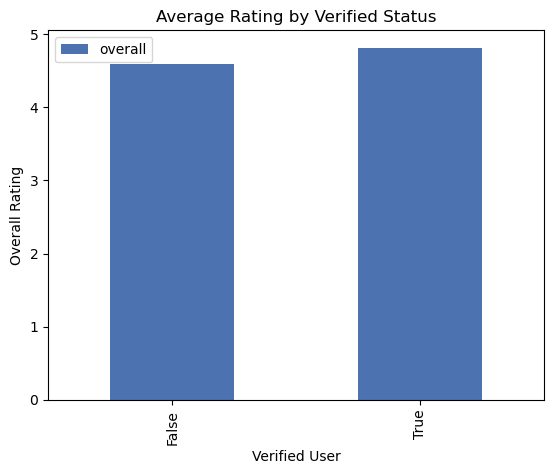

In [16]:
# Ploting the overall rating based on the verified status
avg_rating.plot(kind='bar', title='Average Rating by Verified Status')
plt.xlabel("Verified User")
plt.ylabel("Overall Rating")

2. User verification vs the overall length of review

In [17]:
df['review_length'] = df['reviewText'].str.len()

avg_length = df.groupby("verified")[["review_length"]].mean()
avg_length.head(10)

,review_length
verified,
False,466.945399
True,140.947135


Text(0, 0.5, 'Review_Length')

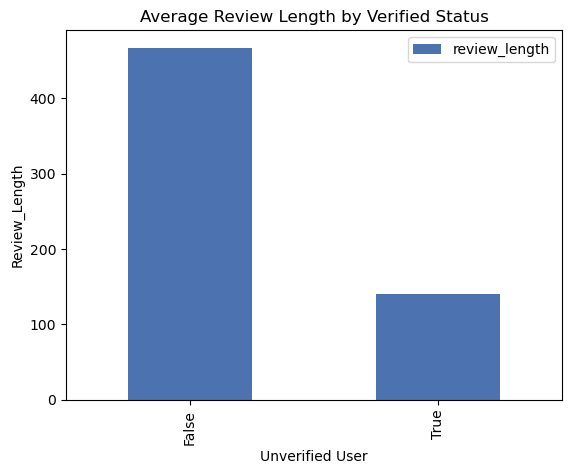

In [18]:
avg_length.plot(kind='bar', title='Average Review Length by Verified Status')
plt.xlabel("Unverified User")
plt.ylabel("Review_Length")

3. Understanding the relationship between review length and rating amongst different user verification status

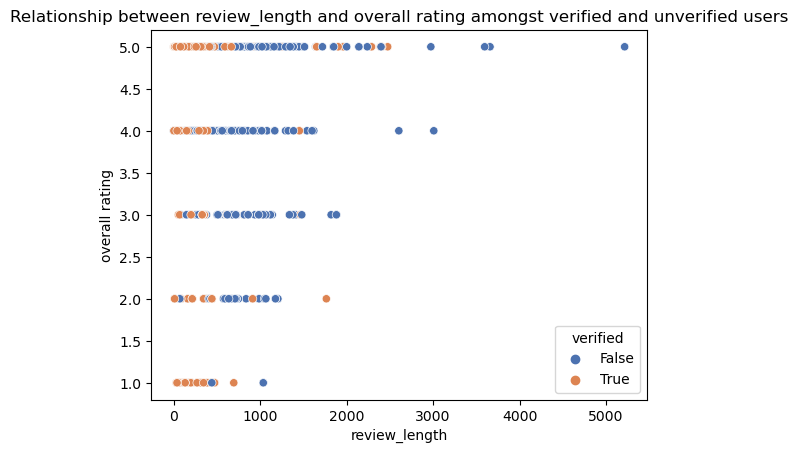

In [19]:
sns.scatterplot(data = df, x = "review_length", y = "overall", hue = "verified")
plt.xlabel("review_length")
plt.ylabel("overall rating")
plt.title("Relationship between review_length and overall rating amongst verified and unverified users");

4. Scatterplot of reviews by verified users based on the rating. 

Here we see the trend of review by the verified users based on the rating given.

Text(0.5, 1.0, 'Review length by unverified user vs. Rating')

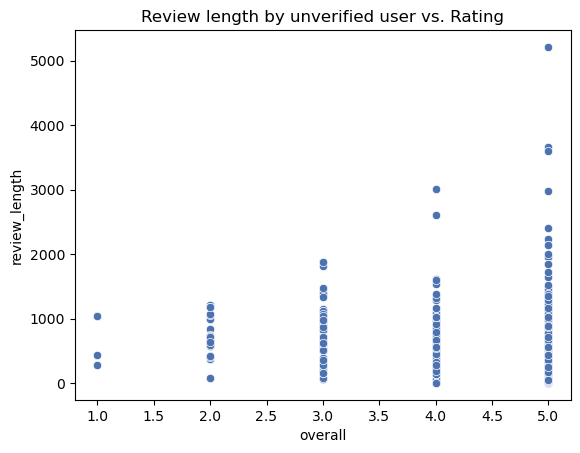

In [20]:
df_unverified = df.loc[df["verified"] == False, :]
sns.scatterplot(data = df_unverified, x = "overall", y = "review_length")
df_unverified.groupby("overall")[["review_length"]].mean()
plt.title('Review length by unverified user vs. Rating')

5. Scatterplot of reviews by verified users based on the rating. 

Here we see the trend of review by the verified users based on the rating given.

Text(0.5, 1.0, 'Review length by verified user vs. Rating')

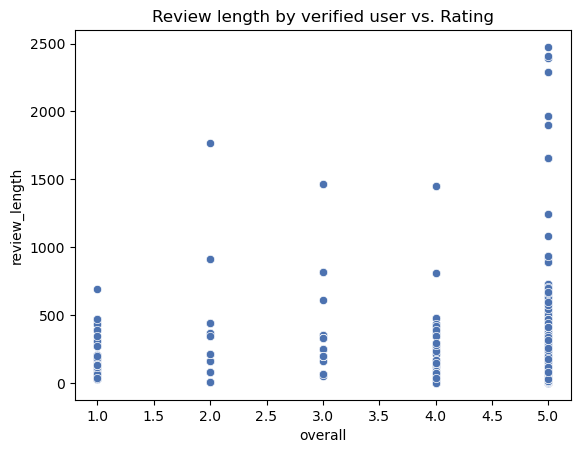

In [21]:
df_verified = df.loc[df["verified"] == True, :]
sns.scatterplot(data = df_verified, x = "overall", y = "review_length")
df_verified.groupby("overall")[["review_length"]].mean()
plt.title('Review length by verified user vs. Rating')